<a href="https://colab.research.google.com/github/kuenliang/Python-3-Data-Analysis-Basics/blob/master/TF%E6%95%B8%E6%93%9A%E9%9B%86%E5%88%86%E9%A1%9E_%E8%94%A6%E5%B0%BE%E8%8A%B1_001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Custom training: walkthrough
##TensorFlow編程
本指南使用這些高級TensorFlow概念：
* 啟用熱切的執行開發環境，
* 使用Datasets API導入數據，
* 使用TensorFlow的Keras API構建模型和圖層。

##TensorFlow programming
This guide uses these high-level TensorFlow concepts:
* Enable an eager execution development environment,
* Import data with the Datasets API,
* Build models and layers with TensorFlow's Keras API.
This tutorial is structured like many TensorFlow programs:

1. Import and parse the data sets.
2. Select the type of model.
3. Train the model.
4. Evaluate the model's effectiveness.
5. Use the trained model to make predictions.


##Setup program ：
1. Configure imports and eager execution
2. Import the required Python modules—including TensorFlow—and enable eager execution for this program. 
3. Eager execution makes TensorFlow evaluate operations immediately, returning concrete values instead of creating a computational graph that is executed later. 4. If you are used to a REPL or the python interactive console, this feels familiar. Eager execution is available in Tensorlow >=1.8.

Once eager execution is enabled, it cannot be disabled within the same program. See the eager execution guide for more details.

In [0]:
from __future__ import absolute_import, division, print_function

import os 
import matplotlib.pyplot as plt

import tensorflow as tf

tf.enable_eager_execution()

print("TensorFlow version:{}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version:1.14.0
Eager execution: True


##The Iris classification problem
* Imagine you are a botanist seeking an automated way to categorize each Iris flower you find. 
* Machine learning provides many algorithms to classify flowers statistically. For instance, a sophisticated machine learning program could classify flowers based on photographs. 
* Our ambitions are more modest—we're going to classify Iris flowers based on the length and width measurements of their sepals and petals.

The Iris genus entails about 300 species, but our program will only classify the following three:

1. Iris setosa
2. Iris virginica
3. Iris versicolor

<table>
  <tr><td>
    <img src="https://www.tensorflow.org/images/iris_three_species.jpg"
         alt="Petal geometry compared for three iris species: Iris setosa, Iris virginica, and Iris versicolor">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://commons.wikimedia.org/w/index.php?curid=170298">Iris setosa</a> (by <a href="https://commons.wikimedia.org/wiki/User:Radomil">Radomil</a>, CC BY-SA 3.0), <a href="https://commons.wikimedia.org/w/index.php?curid=248095">Iris versicolor</a>, (by <a href="https://commons.wikimedia.org/wiki/User:Dlanglois">Dlanglois</a>, CC BY-SA 3.0), and <a href="https://www.flickr.com/photos/33397993@N05/3352169862">Iris virginica</a> (by <a href="https://www.flickr.com/photos/33397993@N05">Frank Mayfield</a>, CC BY-SA 2.0).<br/>&nbsp;
  </td></tr>
</table>


##Import and parse the training dataset
Download the dataset file and convert it into a structure that can be used by this Python program.

###Download the dataset
Download the training dataset file using the [tf.keras.utils.get_file](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file) function. This returns the file path of the downloaded file.

In [0]:
train_dataset_url="https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                          origin=train_dataset_url)

print("Local copy of the dataset file:{}".format(train_dataset_fp))

8192/2194 [================================================================================================================] - 0s 0us/step
Local copy of the dataset file:/root/.keras/datasets/iris_training.csv


##Inspect the data ：
* This dataset, `iris_training.csv`, is a plain text file that stores tabular data formatted as comma-separated values (CSV). 
* Use the `head -n5 `command to take a peak at the first five entries:

In [0]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


###從數據集的此視圖中，請注意以下內容：
1. 第一行是包含有關數據集的信息的標題：
* 總共有120個例子。每個示例都有`四個功能`和`三個可能的標籤名稱`之一。
* 後續行是數據記錄，每行一個示例，其中：`前四個字段是特徵`：這些是示例的特徵。這裡，字段包含代表花卉測量值的浮點數。
* 最後一列是標籤：這是我們想要預測的值。對於此數據集，它是與花名稱對應的整數值0,1或2。

In [0]:
# column order in CSV file
column_names = ['sepal_length','sepal_width', 'petal_length','petal_width' ,'species']

feature_names=column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label:{}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label:species


Each label is associated with string name (for example, "setosa"), but machine learning typically relies on numeric values. The label numbers are mapped to a named representation, such as:

* 0: Iris setosa
* 1: Iris versicolor
* 2: Iris virginica

For more information about features and labels, see the ML Terminology section of the Machine Learning Crash Course.

In [0]:
class_names= ['Iris setosa美', 'Iris versiocolor雜色', 'Iris Virginica']

##創建一個 tf.data.Dataset ：

* 由於數據集是CSV格式的文本文件，因此請使用make_csv_dataset函數將數據解析為合適的格式。
* 由於此函數為訓練模型生成數據，因此默認行為是對數據（`shuffle=True, shuffle_buffer_size=10000`）進行混洗，並永遠重複數據集（`num_epochs=None`）。我們還設置了`batch_size`參數。

In [0]:
batch_size = 32

train_dataset = tf.contrib.data.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

W0813 15:21:59.376907 139797118093184 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0813 15:21:59.378755 139797118093184 deprecation.py:323] From <ipython-input-7-b38e4b2864a1>:8: make_csv_dataset (from tensorflow.contrib.data.python.ops.readers) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.experimental.make_csv_dataset(...)`.
W0813 15:21:59.502829 139797118093184 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/experimental/ops/readers.py:499: parallel_interleave (from tensorflow.python.data.experimental.ops.interleave_ops) is deprecated and will be removed in a fut

In [0]:
features, labels = next(iter(train_dataset))

features

OrderedDict([('sepal_length',
              <tf.Tensor: id=65, shape=(32,), dtype=float32, numpy=
              array([6.9, 5. , 6.4, 5.1, 6. , 4.9, 6. , 6.8, 6.9, 7.4, 5.1, 4.9, 6.1,
                     4.6, 6.2, 5.7, 6.5, 5.5, 6.4, 5. , 4.9, 5. , 7.9, 6.2, 5.7, 6. ,
                     6.5, 6.7, 6.7, 6.3, 5.5, 5. ], dtype=float32)>),
             ('sepal_width',
              <tf.Tensor: id=66, shape=(32,), dtype=float32, numpy=
              array([3.2, 3. , 3.2, 3.8, 2.2, 2.4, 2.9, 3.2, 3.1, 2.8, 3.8, 2.5, 2.8,
                     3.2, 2.2, 2.8, 3. , 3.5, 3.1, 3.6, 3. , 3.5, 3.8, 3.4, 3.8, 2.7,
                     3.2, 3.1, 3. , 3.3, 2.4, 2. ], dtype=float32)>),
             ('petal_length',
              <tf.Tensor: id=63, shape=(32,), dtype=float32, numpy=
              array([5.7, 1.6, 4.5, 1.6, 5. , 3.3, 4.5, 5.9, 5.1, 6.1, 1.9, 4.5, 4. ,
                     1.4, 4.5, 4.5, 5.2, 1.3, 5.5, 1.4, 1.4, 1.6, 6.4, 5.4, 1.7, 5.1,
                     5.1, 5.6, 5.2, 4.7, 3.8, 3.5],

Notice  that like-features are grouped together, or batched. Each example row's fields are appended to the corresponding feature array. 
Change the batch_size to set the number of examples stored in these feature arrays.

You can start to see some clusters by plotting a few features from the batch:

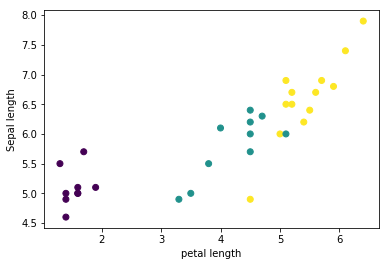

In [0]:
plt.scatter(features['petal_length'].numpy(),
            features['sepal_length'].numpy(),
            c=labels.numpy(),
            cmap='viridis')

plt.xlabel("petal length")
plt.ylabel("Sepal length")
plt.show()

To simplify the model building step, create a function to repackage the features dictionary into a single array with shape:`` (batch_size, num_features)``.


This function uses the `tf.stack `method which takes values from a list of tensors and creates a combined tensor at the specified dimension.

In [0]:
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

Then use the ` tf.data.Dataset.map `method to pack the  `features `of each  ``(features,label)`` pair into the training dataset:

In [0]:
train_dataset = train_dataset.map(pack_features_vector)

The features element of the` Dataset` are now arrays with shape``(batch_size, num_features)``. Let's look at the first few examples:

In [0]:
features, labels =next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[6.9 3.2 5.7 2.3]
 [5.  3.  1.6 0.2]
 [6.4 3.2 4.5 1.5]
 [5.1 3.8 1.6 0.2]
 [6.  2.2 5.  1.5]], shape=(5, 4), dtype=float32)


##Select the type of model
Why model?


## Select the type of model

### Why model?

1. A *[model](https://developers.google.com/machine-learning/crash-course/glossary#model)* is a relationship between `features` and `the label`.  

* For the Iris classification problem, the model defines the relationship between` the sepal and petal` measurements and `the predicted Iris species`. 

* Some simple models can be described with a few` lines of algebra`, but` complex machine learning models` have a large number of parameters that are difficult to summarize.

2. Could you determine the relationship between the four features and the Iris species *without* using machine learning?  
* That is, could you use traditional programming techniques (for example, a lot of conditional statements) to create a model?  Perhaps—if you analyzed the dataset long enough to determine the relationships between` petal and sepal` measurements to a particular species. And this becomes difficult—maybe impossible—on more complicated datasets.
* A good machine learning approach *determines the model for you*. If you feed enough representative examples into the right machine learning model type, the program will figure out the relationships for you.

### Select the model

1. We need to select the kind of model to train. There are many types of models and picking a good one takes experience. 
* This tutorial uses a neural network to solve the Iris classification problem. *[Neural networks](https://developers.google.com/machine-learning/glossary/#neural_network)* can find complex relationships between features and the label. 
* It is a highly-structured graph, organized into one or more *[hidden layers](https://developers.google.com/machine-learning/glossary/#hidden_layer)*. 
* Each hidden layer consists of one or more *[neurons](https://developers.google.com/machine-learning/glossary/#neuron)*. 
* There are several categories of neural networks and this program uses a` dense`, or *[fully-connected neural network](https://developers.google.com/machine-learning/glossary/#fully_connected_layer)*: 
* the neurons in one layer receive input connections from *every* neuron in the previous layer.
For example, Figure 2 illustrates a dense neural network consisting of an` input layer`, two `hidden layers`, and an `output layer`:

<table>
  <tr><td>
    <img src="https://www.tensorflow.org/images/custom_estimators/full_network.png"
         alt="A diagram of the network architecture: Inputs, 2 hidden layers, and outputs">
  </td></tr>
  <tr><td align="center">
    <b>Figure 2.</b> A neural network with features, hidden layers, and predictions.<br/>&nbsp;
  </td></tr>
</table>

When the model from Figure 2 is trained and fed an unlabeled example, it yields three predictions: the likelihood that this flower is the given Iris species. This prediction is called *[inference](https://developers.google.com/machine-learning/crash-course/glossary#inference)*. For this example, the sum of the output predictions is 1.0. In Figure 2, this prediction breaks down as: `0.02` for *Iris setosa*, `0.95` for *Iris versicolor*, and `0.03` for *Iris virginica*. This means that the model predicts—with 95% probability—that an unlabeled example flower is an *Iris versicolor*.

##Create a model using Keras ：
* The TensorFlow` tf.keras` API is the preferred way to create models and layers. 
This makes it easy to build models and experiment while Keras handles the complexity of connecting everything together.

* The` tf.keras.Sequential model` is a linear stack of layers. 
Its constructor takes a list of layer instances, in this case,`two Dense layers` with 10 nodes each, and `an output layer` with 3 nodes representing our label predictions.
* The first layer's input_shape parameter corresponds to the number of features from the dataset, and is required.

In [0]:
 model = tf.keras.Sequential([
     tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
     tf.keras.layers.Dense(10, activation=tf.nn.relu),
     tf.keras.layers.Dense(3)
 ])

The *activation function* determines the output shape of each node in the layer. 
* These non-linearities are important—without them the model would be equivalent to a single layer. 
* There are many available activations, but ReLU is common for hidden layers.

The ideal number of hidden layers and neurons depends on the problem and the dataset.
* Like many aspects of machine learning, picking the best shape of the neural network requires a mixture of knowledge and experimentation.
* As a rule of thumb, increasing the number of hidden layers and neurons typically creates a more powerful model, which requires more data to train effectively.

##Using the model：
Let's have a quick look at what this model does to a batch of features:

In [0]:
predictions = model(features)
predictions[:5]

<tf.Tensor: id=206, shape=(5, 3), dtype=float32, numpy=
array([[-0.5115956 , -0.08028889, -0.57693887],
       [-0.0559656 ,  0.1066469 , -0.1421272 ],
       [-0.34076563, -0.03238136, -0.41694808],
       [-0.18408546,  0.0205173 , -0.24399105],
       [-0.21489766,  0.01228814, -0.3135725 ]], dtype=float32)>

Here, each example returns a [logit](https://developers.google.com/machine-learning/crash-course/glossary#logits) for each class.

To convert these logits to` a probability `for each class, use the [softmax](https://developers.google.com/machine-learning/crash-course/glossary#softmax) function:

In [0]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: id=212, shape=(5, 3), dtype=float32, numpy=
array([[0.2876859 , 0.4428256 , 0.26948857],
       [0.3232034 , 0.3802749 , 0.29652166],
       [0.30414817, 0.41401377, 0.28183803],
       [0.3155678 , 0.38721353, 0.29721862],
       [0.31634554, 0.3970336 , 0.28662086]], dtype=float32)>

Taking the` tf.argmax` across classes gives us the predicted class index. But, the model hasn't been trained yet, so these aren't good predictions.

In [0]:
print("Predictions:{}".format(tf.argmax(predictions, axis=1)))
print ("    Labels:{}".format(labels))

Predictions:[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
    Labels:[2 0 1 0 2 1 1 2 2 2 0 2 1 0 1 1 2 0 2 0 0 0 2 2 0 1 2 2 2 1 1 1]


##訓練模型 ：

* 當模型逐漸優化或模型學習數據集時，訓練是機器學習的階段。目標是充分了解訓練數據集的結構，以便對看不見的數據進行預測。
* 如果您對訓練數據集了解得太多，那麼預測僅適用於它已經看到的數據，並且不會被推廣。這個問題被稱為`過度擬合` - 就像記憶答案而不是理解如何解決問題。

* Iris分類問題是`監督機器學習`*[supervised machine learning](https://developers.google.com/machine-learning/glossary/#supervised_machine_learning)*:的一個例子：模型是從包含標籤的示例中訓練出來的。
* 在`無監督的機器`學習 *[unsupervised machine learning](https://developers.google.com/machine-learning/glossary/#unsupervised_machine_learning)*中，示例不包含標籤。相反，模型通常在特徵中找到模式。

##定義損失和梯度函數 ：
培訓和評估階段都需要計算模型的損失。這可以衡量模型預測與所需標籤的關係，換句話說，模型的執行情況有多糟糕。我們希望最小化或優化此值。

我們的模型將使用*[tf.keras.losses.categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/losses/sparse_softmax_cross_entropy) *函數計算其損失，該函數獲取模型的類概率預測和所需標籤，並返回示例中的平均損失。

In [0]:
def loss(model, x, y):
  y_ =model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

l = loss(model, features, labels)
print("Loss test: {}".format(l))

Loss test: 1.1355464458465576


Use the  [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape)context to calculate the *[gradients](https://developers.google.com/machine-learning/crash-course/glossary#gradient)* used to optimize our model. For more examples of this, see the  [eager execution guide](https://www.tensorflow.org/guide/eager). execution guide.

In [0]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    losses_value = loss(model, inputs, targets)
  return losses_value, tape.gradient(losses_value, model.trainable_variables)

## Create an optimizer

An *[optimizer](https://developers.google.com/machine-learning/crash-course/glossary#optimizer)* applies the computed gradients to the model's variables to minimize the `loss` function. 

* You can think of the loss function as a curved surface (see Figure 3) and we want to find its lowest point by walking around. 
* The gradients point in the direction of steepest ascent—so we'll travel the opposite way and move down the hill. By iteratively calculating the loss and gradient for each batch, we'll adjust the model during training. 
* Gradually, the model will find the best combination of weights and bias to minimize loss. And the lower the loss, the better the model's predictions.

<table>
  <tr><td>
    <img src="https://cs231n.github.io/assets/nn3/opt1.gif" width="70%"
         alt="Optimization algorithms visualized over time in 3D space.">
  </td></tr>
  <tr><td align="center">
    <b>Figure 3.</b> Optimization algorithms visualized over time in 3D space.<br/>(Source: <a href="http://cs231n.github.io/neural-networks-3/">Stanford class CS231n</a>, MIT License, Image credit: <a href="https://twitter.com/alecrad">Alec Radford</a>)
  </td></tr>
</table>

TensorFlow has many [optimization algorithms](https://www.tensorflow.org/api_guides/python/train) available for training. This model uses the [tf.train.GradientDescentOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer) that implements the *[stochastic gradient descent](https://developers.google.com/machine-learning/crash-course/glossary#gradient_descent)* (SGD) algorithm. The `learning_rate` sets the step size to take for each iteration down the hill. This is a *hyperparameter* that you'll commonly adjust to achieve better results.

###Let's setup the optimizer and the global_step counter:

In [0]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
global_step = tf.Variable(0)

###We'll use this to calculate a single optimization step:

In [0]:
losses_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(global_step.numpy(),
                                          losses_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables), global_step)

print("Step: {},         Loss: {}".format(global_step.numpy(),
                                          loss(model, features, labels).numpy()))

Step: 0, Initial Loss: 1.1355464458465576
Step: 1,         Loss: 1.133716106414795


##訓練循環( Training loop) ：

With all the pieces in place, the model is ready for training! A training loop feeds the dataset examples into the model to help it make better predictions. The following code block sets up these training steps:

1. Iterate each *epoch*. An epoch is one pass through the dataset.
2. Within an epoch, iterate over each example in the training `Dataset` grabbing its *features* (`x`) and *label* (`y`).
3. Using the example's features, make a prediction and compare it with the label. Measure the inaccuracy of the prediction and use that to calculate the model's loss and gradients.
4. Use an `optimizer` to update the model's variables.
5. Keep track of some stats for visualization.
6. Repeat for each epoch.

The `num_epochs` variable is the number of times to loop over the dataset collection. Counter-intuitively, training a model longer does not guarantee a better model. `num_epochs` is a *[hyperparameter](https://developers.google.com/machine-learning/glossary/#hyperparameter)* that you can tune. Choosing the right number usually requires both experience and experimentation.